## Sentiment Analysis of IMDb Movie Reviews

1. Data Pre-processing
2. CountVectorizer and TF-IDF
3. Models- Naive Bayes, Logistic Regression

In [1]:
import nltk
import pandas as pd
import numpy as np

import re
import string
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.corpus import stopwords
from nltk import pos_tag

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

from wordcloud import WordCloud,STOPWORDS
from PIL import Image

### Data Description

The dataset contains 50K movie reviews for natural language processing or Text analytics. This is a dataset for binary sentiment classification. The dataset contains an even number of positive and negative reviews. The authors considered only highly polarized reviews. Neutral reviews are not included in the dataset.

Download: https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

In [2]:
data = pd.read_csv('/Users/shalinisingh/Desktop/Projects/IMDB-Sentiment/IMDB_MovieReviews.csv')
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
data.count()

review       50000
sentiment    50000
dtype: int64

In [4]:
data['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

Text preprocessing:
- to lowecase
- remove hyperlinks
- remove @mentions
- remove punctuation
- remove numeric
- remove non a-z 0-9 characters and words shorter than 1 characters 

In [5]:
def remove_features(data_str): # compile regex
    url_re = re.compile('https?://(www.)?\w+\.\w+(/\w+)*/?') 
    punc_re = re.compile('[%s]' % re.escape(string.punctuation)) 
    num_re = re.compile('(\\d+)')
    mention_re = re.compile('@(\w+)')
    alpha_num_re = re.compile("^[a-z0-9_.]+$")
    # convert to lowercase
    data_str = data_str.lower()
    # remove hyperlinks
    data_str = url_re.sub(' ', data_str)
    # remove @mentions
    data_str = mention_re.sub(' ', data_str)
    # remove puncuation
    data_str = punc_re.sub(' ', data_str)
    # remove numeric 'words'
    data_str = num_re.sub(' ', data_str)
    # remove non a-z 0-9 characters and words shorter than 1 characters 
    list_pos = 0
    cleaned_str = ''
    for word in data_str.split():
        if list_pos == 0:
            if alpha_num_re.match(word) and len(word) > 1:
                cleaned_str = word 
            else:
                cleaned_str = ' '
        else:
            if alpha_num_re.match(word) and len(word) > 1:
                cleaned_str = cleaned_str + ' ' + word 
            else:
                cleaned_str += ' '
        list_pos += 1
    
    return " ".join(cleaned_str.split())

Lemmatization

In [6]:
def lemmatize(data_str):
    # expects a string
    list_pos = 0
    cleaned_str = ''
    lmtzr = WordNetLemmatizer() 
    text = data_str.split() 
    tagged_words = pos_tag(text) 
    for word in tagged_words:
        if 'v' in word[1].lower():
            lemma = lmtzr.lemmatize(word[0], pos='v')
        else:
            lemma = lmtzr.lemmatize(word[0], pos='n')
        if list_pos == 0: 
            cleaned_str = lemma
        else:
            cleaned_str = cleaned_str + ' ' + lemma
        list_pos += 1 
    return cleaned_str

In [7]:
# Cleaning Data
data_clean = []
for i in range(len(data)):
    res = remove_features(data['review'][i])
    res1 = lemmatize(res)
    data_clean.append(res1)

In [8]:
reviews = pd.DataFrame()
reviews[1] = data_clean
reviews[2] = data['sentiment']
reviews.columns = ['review','sentiment']

In [9]:
reviews['review'].values[1]

'wonderful little production br br the filming technique be very unassuming very old time bbc fashion and give comfort and sometimes discomforting sense of realism to the entire piece br br the actor be extremely well choose michael sheen not only have get all the polari but he have all the voice down pat too you can truly see the seamless edit guide by the reference to williams diary entry not only be it well worth the watching but it be terrificly write and perform piece masterful production about one of the great master of comedy and his life br br the realism really come home with the little thing the fantasy of the guard which rather than use the traditional dream technique remain solid then disappear it play on our knowledge and our sens particularly with the scene concern orton and halliwell and the set particularly of their flat with halliwell mural decorate every surface be terribly well do'

In [10]:
reviews.head()

,review,sentiment
0,one of the other reviewer have mention that af...,positive
1,wonderful little production br br the filming ...,positive
2,thought this be wonderful way to spend time on...,positive
3,basically there family where little boy jake t...,negative
4,petter mattei love in the time of money be vis...,positive


### Text Classification Models

The final step is the Model Building step in which a machine learning model is trained on a labelled dataset.

Prepare the data for modeling:
* Split the data into training and test sets. You should have four sets of data - X_train, X_test, y_train, y_test

In [11]:
#split the dataset  
#train dataset
X_train=reviews.review[:30000]
Y_train=reviews.sentiment[:30000]
#test dataset
X_test=reviews.review[30000:]
Y_test=reviews.sentiment[30000:]
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(30000,) (30000,)
(20000,) (20000,)


Create numerical features:
* Count Vectorizer: Terms should be unigrams (single words), and values should be word counts
* TF-IDF Vectorizer

In [12]:
cv = CountVectorizer(stop_words='english')
X_train_cv = cv.fit_transform(X_train) # fit_transform learns the vocab and one-hot encodes
X_test_cv = cv.transform(X_test) # transform uses the same vocab and one-hot encodes
# print the dimensions of the training set (text messages, terms)
print(X_train_cv.toarray().shape)

(30000, 68965)


In [13]:
X_train_cv = pd.DataFrame(X_train_cv.toarray(), columns=cv.get_feature_names())
X_test_cv = pd.DataFrame(X_test_cv.toarray(), columns=cv.get_feature_names())

In [14]:
tv = TfidfVectorizer(stop_words="english")
X_train_tv = tv.fit_transform(X_train) # fit_transform learns the vocab and one-hot encodes
X_test_tv = tv.transform(X_test) # transform uses the same vocab and one-hot encodes
print(X_train_tv.toarray().shape)

(30000, 68965)


In [15]:
X_train_tv = pd.DataFrame(X_train_tv.toarray(), columns=tv.get_feature_names())
X_test_tv = pd.DataFrame(X_test_tv.toarray(), columns=tv.get_feature_names())

###    1. Naive Bayes
#### 1.1 Naive Bayes using CountVectorizer

In [16]:
nb = MultinomialNB()
# Train the model
nb.fit(X_train_cv, Y_train)
# Take the model that was trained on the X_train_cv data and apply it to the X_test_cv data
y_pred_cv_nb = nb.predict(X_test_cv)
y_pred_cv_nb

array(['negative', 'negative', 'negative', ..., 'negative', 'positive',
       'negative'], dtype='<U8')

Accuracy: 0.85
Precision: 0.864
Recall: 0.831
F1 Score: 0.847


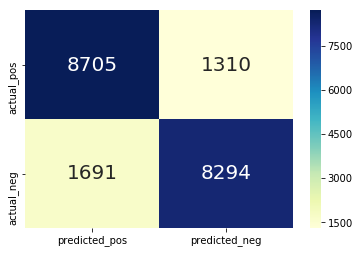

In [19]:
cm = confusion_matrix(Y_test, y_pred_cv_nb)
sns.heatmap(cm, xticklabels=['predicted_pos', 'predicted_neg'], yticklabels=['actual_pos', 'actual_neg'], annot=True, fmt='d', annot_kws={'fontsize':20}, cmap="YlGnBu");
true_neg, false_pos = cm[0]
false_neg, true_pos = cm[1]
accuracy = round((true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg),3)
precision = round((true_pos) / (true_pos + false_pos),3)
recall = round((true_pos) / (true_pos + false_neg),3)
f1 = round(2 * (precision * recall) / (precision + recall),3)
print('Accuracy: {}'.format(accuracy))
print('Precision: {}'.format(precision))
print('Recall: {}'.format(recall))
print('F1 Score: {}'.format(f1))

#### 1.2 Naive Bayes using tf-idf

In [20]:
nb = MultinomialNB()
# Train the model
nb.fit(X_train_tv, Y_train)
# Take the model that was trained on the X_train_cv data and apply it to the X_test_cv data
y_pred_tv_nb = nb.predict(X_test_tv)
y_pred_tv_nb

array(['negative', 'negative', 'negative', ..., 'negative', 'positive',
       'negative'], dtype='<U8')

Accuracy: 0.859
Precision: 0.869
Recall: 0.844
F1 Score: 0.856


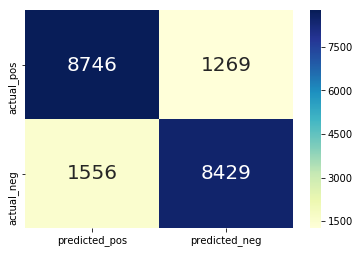

In [21]:
cm = confusion_matrix(Y_test, y_pred_tv_nb)
sns.heatmap(cm, xticklabels=['predicted_pos', 'predicted_neg'], yticklabels=['actual_pos', 'actual_neg'], annot=True, fmt='d', annot_kws={'fontsize':20}, cmap="YlGnBu");
true_neg, false_pos = cm[0]
false_neg, true_pos = cm[1]
accuracy = round((true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg),3)
precision = round((true_pos) / (true_pos + false_pos),3)
recall = round((true_pos) / (true_pos + false_neg),3)
f1 = round(2 * (precision * recall) / (precision + recall),3)
print('Accuracy: {}'.format(accuracy))
print('Precision: {}'.format(precision))
print('Recall: {}'.format(recall))
print('F1 Score: {}'.format(f1))

###   2. Logistic Regression
#### 2.1 Logistic Regression using Count Vectorizer

In [17]:
 # Use a logistic regression model
lr = LogisticRegression()
# Train the model
lr.fit(X_train_cv, Y_train)
# Take the model that was trained on the X_train_cv data and apply it to the X_test_cv data
y_pred_cv = lr.predict(X_test_cv)
y_pred_cv

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array(['positive', 'negative', 'negative', ..., 'positive', 'positive',
       'negative'], dtype=object)

Accuracy: 0.878
Precision: 0.873
Recall: 0.883
F1 Score: 0.878


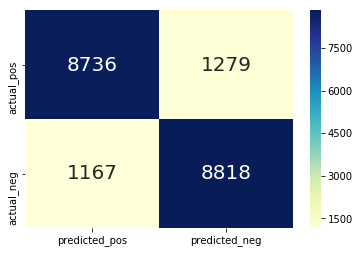

In [18]:
cm = confusion_matrix(Y_test, y_pred_cv)
sns.heatmap(cm, xticklabels=['predicted_pos', 'predicted_neg'], yticklabels=['actual_pos', 'actual_neg'], annot=True, fmt='d', annot_kws={'fontsize':20}, cmap="YlGnBu");
true_neg, false_pos = cm[0]
false_neg, true_pos = cm[1]
accuracy = round((true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg),3)
precision = round((true_pos) / (true_pos + false_pos),3)
recall = round((true_pos) / (true_pos + false_neg),3)
f1 = round(2 * (precision * recall) / (precision + recall),3)
print('Accuracy: {}'.format(accuracy))
print('Precision: {}'.format(precision))
print('Recall: {}'.format(recall))
print('F1 Score: {}'.format(f1))

#### 2.2 Logistic Regression using tf-idf

In [19]:
# Train the model
lr.fit(X_train_tv, Y_train)
# Take the model that was trained on the X_train_cv data and apply it to the X_test_cv data
y_pred_tv = lr.predict(X_test_tv)
y_pred_tv

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array(['negative', 'negative', 'negative', ..., 'negative', 'positive',
       'negative'], dtype=object)

Accuracy: 0.886
Precision: 0.874
Recall: 0.901
F1 Score: 0.887


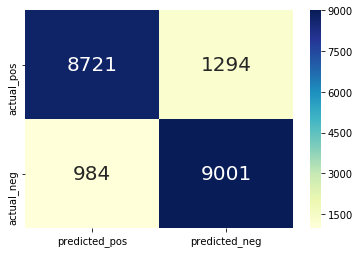

In [20]:
cm = confusion_matrix(Y_test, y_pred_tv)
sns.heatmap(cm, xticklabels=['predicted_pos', 'predicted_neg'], yticklabels=['actual_pos', 'actual_neg'], annot=True, fmt='d', annot_kws={'fontsize':20}, cmap="YlGnBu");
true_neg, false_pos = cm[0]
false_neg, true_pos = cm[1]
accuracy = round((true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg),3)
precision = round((true_pos) / (true_pos + false_pos),3)
recall = round((true_pos) / (true_pos + false_neg),3)
f1 = round(2 * (precision * recall) / (precision + recall),3)
print('Accuracy: {}'.format(accuracy))
print('Precision: {}'.format(precision))
print('Recall: {}'.format(recall))
print('F1 Score: {}'.format(f1))

## Word Cloud

In [23]:
wc_string = reviews['review'].str.cat(sep=' ')

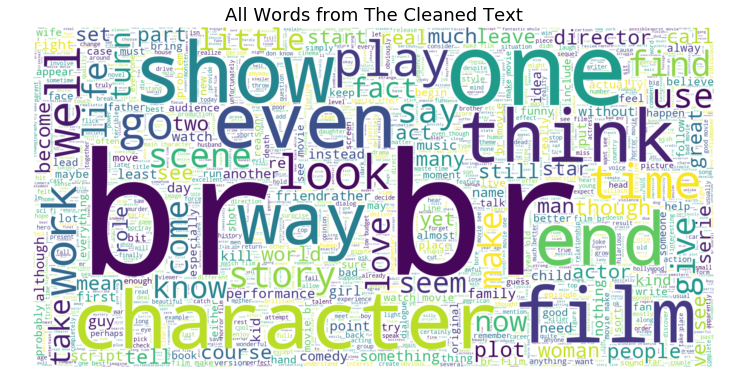

In [24]:
wc = WordCloud(width=1600, height=800,background_color="white", max_words=2000).generate(wc_string)
plt.figure(figsize=(10,10))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.title('All Words from The Cleaned Text', fontsize=18)
plt.show()

#### Positive Sentiment

In [25]:
pos_string = reviews[reviews.sentiment == 'positive']['review'].str.cat(sep=' ')

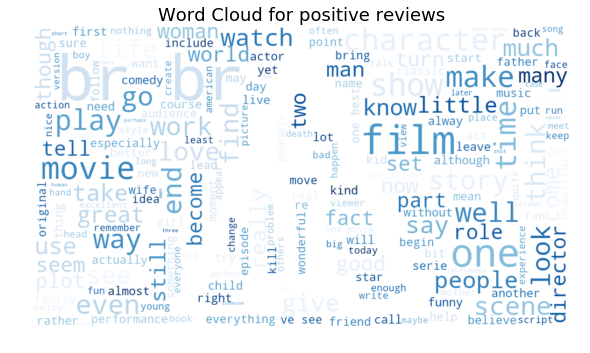

In [27]:
twitter_mask = np.array(Image.open("/Users/shalinisingh/Desktop/Projects/IMDB-Sentiment/oscars-logo.jpg"))
wc = WordCloud(width=1600, height=800,background_color="white", colormap="Blues",mask=twitter_mask).generate(pos_string)
plt.figure(figsize=(8,8))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.title('Word Cloud for positive reviews', fontsize=18)
plt.show()

#### Negative Sentiment

In [28]:
neg_string = reviews[reviews.sentiment == 'negative']['review'].str.cat(sep=' ')

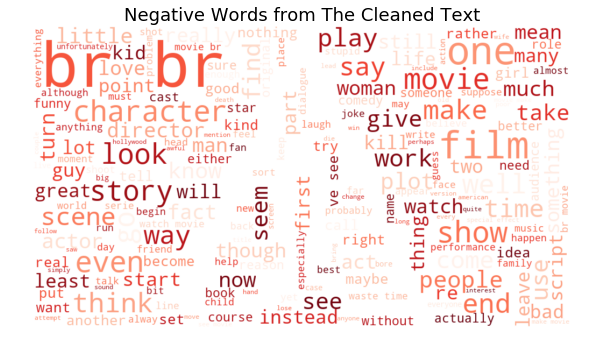

In [29]:
twitter_mask = np.array(Image.open("/Users/shalinisingh/Desktop/Projects/IMDB-Sentiment/oscars-logo.jpg"))
wc = WordCloud(width=1600, height=800,background_color="white", colormap="Reds",mask=twitter_mask).generate(neg_string)
plt.figure(figsize=(8,8))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.title('Negative Words from The Cleaned Text', fontsize=18)
plt.show()